In [43]:
import tensorflow as tf
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import sklearn.metrics as sk_metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
import tempfile
import statsmodels.api as sm
import os
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.feature_selection import SelectKBest
from sklearn import metrics
import pymssql
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from tqdm import tqdm
import numpy as np
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from xgboost import plot_importance
from scipy import stats
from sklearn.preprocessing import StandardScaler

# Preset matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

print(tf.__version__)
# To make the results reproducible, set the random seed value.
tf.random.set_seed(22)

2.9.2


In [44]:
conn = pymssql.connect(server='localhost', user='sa', password='Sprpwd1234', database='Loans_2023_01_27')
cursor = conn.cursor()

def get_column_index(cursor, column_name):
    for index, col in enumerate(cursor.description):
        if col[0] == column_name:
            return index

additional_data_headers = ["RentMortgagePayment" ,"TotalIncome" ,"RentMortgage" ,"CarPayment" ,"Expenses" ,"AvailableIncome" ,"Miles"]
additional_data_sql = "VIN,"
for i, header in enumerate(additional_data_headers):
    additional_data_sql += header
    if i!=len(additional_data_headers)-1:
        additional_data_sql+=','

headers = []
rows = []

# Underwriting Data
cursor.execute("SELECT * FROM dbo.UnderwritingData")

for entity in cursor.description:
    headers.append(entity[0])

vin_index = get_column_index(cursor, "VIN")

res = cursor.fetchone()
while res:
    row = [element for element in res]
    if row[vin_index] is not None:
        row[vin_index] = row[vin_index][-6:]
        rows.append(row)
    res = cursor.fetchone()

df = pd.DataFrame(rows, columns=headers)


#Additional Data
cursor.execute("Select {vCols} FROM dbo.VerificationsDec".format(vCols = additional_data_sql))

addl_data_rows = []
res = cursor.fetchone()

while res:
    row = [element for element in res]
    row[0] = row[0].strip()[-6:]
    addl_data_rows.append(row)
    res = cursor.fetchone()

print("Assigning Additional Entities")
for data in tqdm(addl_data_rows):
    df.loc[df['VIN']==data[0], additional_data_headers] = data[1:]

#Results from RawAlgorithmData
cursor.execute("SELECT Vin6,ProcStatsCd,Delq FROM dbo.RawAlgorithmData")
res = cursor.fetchone()
loan_results = dict()
delq_results = dict()
while res:
    vin6 = res[0].strip()[-6:]
    loan_results[vin6] = res[1].strip()
    delq_results[vin6] = res[2]
    res = cursor.fetchone()

default_result = ["NA" for i in range(len(df))]
default_delq = ["NA" for i in range(len(df))]
df['Result'] = default_result
df['Delq'] = default_delq

df = df[df['OpeningBalance']!=0]

print("Assigning Results")
for vin6, res in tqdm(loan_results.items()):
    df.loc[df['VIN'] == vin6, ['Result', 'Delq']] = [res, delq_results[vin6]]

df = df[["RentMortgagePayment" ,"TotalIncome" ,"CarPayment" ,"Expenses" ,"AvailableIncome" ,"Miles", "OpeningBalance","Salary","Term","VehicleYear","CreaditScore","LTV","DTI","TradelinesTotal","TradelinesBalance","Reposessions","Bankrupcies","Chageoff","Mortgage","NinetyDaysDelinquent","InquiresTotal","OpenTotal","ClosedTotalTermsNotPaid","LatePaymentHistory001230","LatePaymentHistory001260","LatePaymentHistory001290Plus","PaidAccounts","InquiriesLast6Months","OpenTotalInBadStatus","CurrentPaymentsMade","RentMortgage","CashDown","HomeOwner", "Delq", "Result"]]

print(df['Delq'])

df = df[(df['Result']=='CO') | (df['Result']=='CL')]
df['Result'].replace(to_replace=['CO', 'CL'], value=[0,1], inplace=True)
df['HomeOwner'].replace(to_replace=['N', 'Y'], value=[0,1], inplace=True)
df['DelqPct'] = df.apply(lambda row : (100*row['Delq'])/row['OpeningBalance'],axis=1)
df.fillna(df.mean(), inplace=True)

df = df[["RentMortgagePayment" ,"TotalIncome" ,"CarPayment" ,"Expenses" ,"AvailableIncome" ,"Miles", "OpeningBalance","Salary","Term","VehicleYear","CreaditScore","LTV","DTI","TradelinesTotal","TradelinesBalance","Reposessions","Bankrupcies","Chageoff","Mortgage","NinetyDaysDelinquent","InquiresTotal","OpenTotal","ClosedTotalTermsNotPaid","LatePaymentHistory001230","LatePaymentHistory001260","LatePaymentHistory001290Plus","PaidAccounts","InquiriesLast6Months","OpenTotalInBadStatus","CurrentPaymentsMade","RentMortgage","CashDown","HomeOwner", "DelqPct"]]
print(df['DelqPct'])

Assigning Additional Entities


100%|████████████████████████████████████| 28023/28023 [00:38<00:00, 729.42it/s]


Assigning Results


100%|████████████████████████████████████| 24961/24961 [00:31<00:00, 798.23it/s]


0           0
1           0
2           0
3        1266
4           0
         ... 
17657      NA
17658      NA
17659      NA
17660      NA
17661      NA
Name: Delq, Length: 17660, dtype: object
0         0.000000
1         0.000000
2         0.000000
3         8.573042
4         0.000000
           ...    
17361     0.000000
17536     0.000000
17560     1.589734
17588     0.000000
17639    13.178456
Name: DelqPct, Length: 10306, dtype: float64


In [45]:
#outlier removal
nooutliers = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

nooutliers.describe()

,RentMortgagePayment,TotalIncome,CarPayment,Expenses,AvailableIncome,Miles,OpeningBalance,Salary,Term,VehicleYear,...,LatePaymentHistory001260,LatePaymentHistory001290Plus,PaidAccounts,InquiriesLast6Months,OpenTotalInBadStatus,CurrentPaymentsMade,RentMortgage,CashDown,HomeOwner,DelqPct
count,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,...,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.0,7995.000000
mean,53.353422,2823.900957,347.571436,613.563337,1966.181143,108008.849799,10388.244969,2769.428143,44.702814,2011.216635,...,0.821764,3.158474,1.620763,6.124703,3.552345,15.228393,57.671862,2113.515072,0.0,3.866041
std,141.547289,1189.492183,59.989759,262.817092,1329.686471,32361.482313,2617.738162,1173.046510,6.972388,3.100977,...,1.352867,6.094332,2.376501,5.542709,3.284691,25.350288,137.587731,930.490966,0.0,5.184910
min,0.000000,0.000000,120.290000,288.570000,-1633.950000,1790.000000,3625.530000,0.000000,24.000000,1997.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,0.000000,2000.000000,304.715000,433.640000,1361.555000,87231.500000,8447.930000,2000.000000,42.000000,2009.000000,...,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,1500.000000,0.0,0.000000
50%,0.000000,2539.200000,351.800000,519.060000,1904.710000,108145.000000,10172.890000,2500.000000,48.000000,2012.000000,...,0.000000,0.000000,1.000000,5.000000,3.000000,3.000000,0.000000,2000.000000,0.0,0.000000
75%,0.000000,3291.500000,380.710000,716.635575,2537.165000,130550.500000,12082.800000,3200.000000,48.000000,2013.000000,...,1.000000,4.000000,2.000000,9.000000,5.000000,20.000000,1.000000,2500.000000,0.0,7.301879
max,780.000000,9000.000000,587.270000,2846.590000,8480.350000,229370.000000,19734.010000,8374.000000,66.000000,2019.000000,...,7.000000,40.000000,15.000000,28.000000,16.000000,172.000000,750.000000,6000.000000,0.0,20.395001


In [46]:
#minmax normalization
normalized_df=(df-df.min())/(df.max()-df.min())

normalized_df.describe()

,RentMortgagePayment,TotalIncome,CarPayment,Expenses,AvailableIncome,Miles,OpeningBalance,Salary,Term,VehicleYear,...,LatePaymentHistory001260,LatePaymentHistory001290Plus,PaidAccounts,InquiriesLast6Months,OpenTotalInBadStatus,CurrentPaymentsMade,RentMortgage,CashDown,HomeOwner,DelqPct
count,10306.000000,10306.000000,10306.000000,10306.000000,10306.000000,10306.000000,10306.000000,10306.000000,10306.000000,10306.000000,...,10306.000000,10306.000000,10306.000000,10306.000000,10306.000000,10306.000000,10306.000000,10306.000000,10306.000000,10306.000000
mean,0.023988,0.047260,0.091713,0.010904,0.407044,0.072943,0.214469,0.046342,0.649297,0.994819,...,0.041786,0.020341,0.039913,0.083493,0.079215,0.043204,0.024589,0.131822,0.028430,0.123956
std,0.067539,0.032084,0.022592,0.018186,0.021571,0.028581,0.085096,0.027733,0.121255,0.017050,...,0.073676,0.048547,0.068264,0.085510,0.083957,0.082119,0.065051,0.077720,0.166206,0.173071
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.032219,0.077916,0.004172,0.399419,0.057941,0.154959,0.030769,0.573770,0.994062,...,0.000000,0.000000,0.000000,0.023810,0.019608,0.000000,0.000000,0.088235,0.000000,0.000000
50%,0.000000,0.040615,0.091713,0.006926,0.405364,0.072943,0.205773,0.040000,0.704918,0.995547,...,0.000000,0.000000,0.015625,0.059524,0.058824,0.011609,0.000000,0.117647,0.000000,0.000000
75%,0.000000,0.053846,0.101265,0.011872,0.412285,0.088347,0.262825,0.053846,0.704918,0.996042,...,0.071429,0.020576,0.046875,0.119048,0.117647,0.049751,0.024589,0.147059,0.000000,0.229719
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [47]:
#log transformation
log_transformed_df = df.apply(lambda x: np.log10(x) if np.issubdtype(x.dtype, np.number) else x)

log_transformed_df.describe()

/Users/me/miniforge3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/me/miniforge3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/me/miniforge3/lib/python3.9/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/me/miniforge3/lib/python3.9/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/me/miniforge3/lib/python3.9/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/me/miniforge3/lib/python3.9/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  dif

,RentMortgagePayment,TotalIncome,CarPayment,Expenses,AvailableIncome,Miles,OpeningBalance,Salary,Term,VehicleYear,...,LatePaymentHistory001260,LatePaymentHistory001290Plus,PaidAccounts,InquiriesLast6Months,OpenTotalInBadStatus,CurrentPaymentsMade,RentMortgage,CashDown,HomeOwner,DelqPct
count,1.030600e+04,1.030600e+04,10306.000000,10306.000000,9137.000000,10306.000000,10306.000000,1.030600e+04,10306.000000,1.030600e+04,...,1.030600e+04,1.030600e+04,1.030600e+04,1.030600e+04,1.030600e+04,1.030600e+04,1.030600e+04,1.030600e+04,10306.0,1.030600e+04
mean,-inf,-inf,2.539927,2.795634,3.312563,5.004644,4.007315,-inf,1.642459,-inf,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
std,NaN,NaN,0.084162,0.198283,0.246467,0.167948,0.122788,NaN,0.081236,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-inf,-inf,1.554004,2.434217,0.907949,3.252853,3.460844,-inf,0.698970,-inf,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
25%,NaN,3.321029e+00,2.485335,2.645408,3.187095,4.934616,3.926747,3.301030e+00,1.602060,3.302980e+00,...,NaN,NaN,NaN,3.010300e-01,0.000000e+00,NaN,NaN,3.176091e+00,NaN,NaN
50%,NaN,3.421604e+00,2.548416,2.743792,3.310049,5.032749,4.011593,3.414973e+00,1.681241,3.303628e+00,...,NaN,NaN,0.000000e+00,6.989700e-01,4.771213e-01,8.450980e-01,NaN,3.301030e+00,NaN,NaN
75%,NaN,3.544068e+00,2.587273,2.878585,3.443524,5.114702,4.090502,3.544068e+00,1.681241,3.303844e+00,...,3.010300e-01,6.989700e-01,4.771213e-01,1.000000e+00,7.781513e-01,1.477121e+00,1.934802e+00,3.397940e+00,NaN,8.631289e-01
max,3.544068e+00,4.812913e+00,3.544068,4.613516,4.788579,6.163033,4.588369,4.812913e+00,1.819544,3.305566e+00,...,1.447158e+00,2.385606e+00,1.806180e+00,1.924279e+00,1.707570e+00,2.780317e+00,3.544068e+00,4.230449e+00,0.0,1.501932e+00


In [48]:
# fig, axes = plt.subplots(ncols=3)
# for i, yvar in enumerate(df.columns):
#     axes[i].scatter(df['Result'],df[yvar])

# pp = sns.pairplot(data=df,
#                   y_vars=["DelqPct"],
#                   x_vars=df.columns)

In [49]:
x_train, x_test, y_train, y_test = train_test_split(
    df.iloc[:,:-1], df.iloc[:,-1:], test_size=0.2, random_state=42)


resdict= dict()
rdict = dict()

num_features = [i for i in range(1, len(df.columns)-2)]

# for nf in tqdm(num_features):
#     linReg = LinearRegression()
#     rfe = RFE(estimator = linReg, n_features_to_select = nf)
#     rfe.fit(x_train, y_train.values.ravel())
#
#
#     train_pred = rfe.predict(x_train)
#     test_pred = rfe.predict(x_test)
#
#     resdict[nf] = np.sqrt(metrics.mean_squared_error(y_test, test_pred))
#     rdict[nf] = metrics.r2_score(y_test, test_pred)

print(resdict)
print(rdict)

linReg = LinearRegression()
rfe = RFE(estimator = linReg, n_features_to_select = 59)
rfe.fit(x_train, y_train.values.ravel())


train_pred = rfe.predict(x_train)
test_pred = rfe.predict(x_test)

print("LinearRegression")
print("R^2 : ", metrics.r2_score(y_test, test_pred))
print("MAE :", metrics.mean_absolute_error(y_test,test_pred))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, test_pred)))


{}
{}
LinearRegression
R^2 :  0.07157679040868947
MAE : 4.300789401140549
RMSE: 5.268459343081297


In [50]:
# print(y_train)

x_train = sm.add_constant(x_train)
est = sm.OLS(y_train, x_train).fit()
print(est.summary())


                            OLS Regression Results                            
Dep. Variable:                DelqPct   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     23.86
Date:                Wed, 08 Mar 2023   Prob (F-statistic):          3.58e-133
Time:                        11:07:48   Log-Likelihood:                -25392.
No. Observations:                8244   AIC:                         5.085e+04
Df Residuals:                    8211   BIC:                         5.108e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [51]:
x_test = sm.add_constant(x_test)

print(est.predict(x_train[:5]))
print(y_train[:5])


636      4.108177
236      4.997236
10676    2.951293
9936     4.196345
9262     6.987687
dtype: float64
         DelqPct
636    13.863232
236     8.154454
10676   0.744027
9936    0.000000
9262   10.048679


### TensorFlow

In [52]:
train_features, test_features, train_labels, test_labels = train_test_split(
    df.iloc[:,:-1], df.iloc[:,-1:], test_size=0.2, random_state=42)


normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())


2023-03-08 11:07:48.861346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-08 11:07:48.915108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[8.35630722e+01 3.05338403e+03 3.53715759e+02 7.15448181e+02
  2.06968311e+03 1.07979305e+05 1.05801855e+04 3.00872656e+03
  4.45686455e+01 2.01085938e+03 4.54750702e+02 1.32967341e+00
  2.76270419e-01 9.87008286e+00 2.20259375e+04 1.29427552e-01
  3.88161070e-03 1.46288204e+00 2.94759907e-02 4.03469372e+00
  1.37003851e+01 5.69772053e+00 4.45076408e+01 1.73107731e+00
  1.17819047e+00 4.97052574e+00 2.56950521e+00 7.00060511e+00
  4.03178310e+00 2.61943283e+01 8.57807617e+01 2.24153906e+03
  2.94759907e-02]]


In [53]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [54]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 33)               67        
 ion)                                                            
                                                                 
 dense_3 (Dense)             (None, 64)                2176      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,468
Trainable params: 6,401
Non-trainable params: 67
_________________________________________________________________


In [55]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

2023-03-08 11:07:49.709039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-08 11:07:50.805741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


CPU times: user 1min 21s, sys: 43.1 s, total: 2min 4s
Wall time: 1min 42s


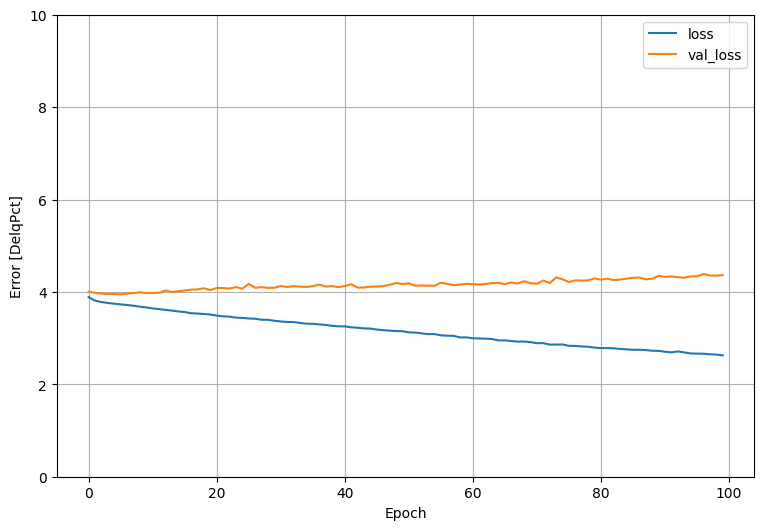

In [56]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [DelqPct]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

#Overfitting is when the model fits the training data too closely, and the loss keeps decreasing while the val_loss is stale, or increases.
#which looks to be exactly what is happening here

In [57]:
test_results = dict()
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)
pd.DataFrame(test_results, index=['Mean absolute error [DelqPCT]']).T

,Mean absolute error [DelqPCT]
dnn_model,4.38892


65/65 [==============================] - 0s 2ms/step


2023-03-08 11:09:31.905847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[ 0.44031122  5.6933193  -0.18954054  0.94019634 10.80282   ]
        DelqPct
2458   9.560600
6532   0.000000
4339   9.146635
3065  11.170000
5488  17.009102


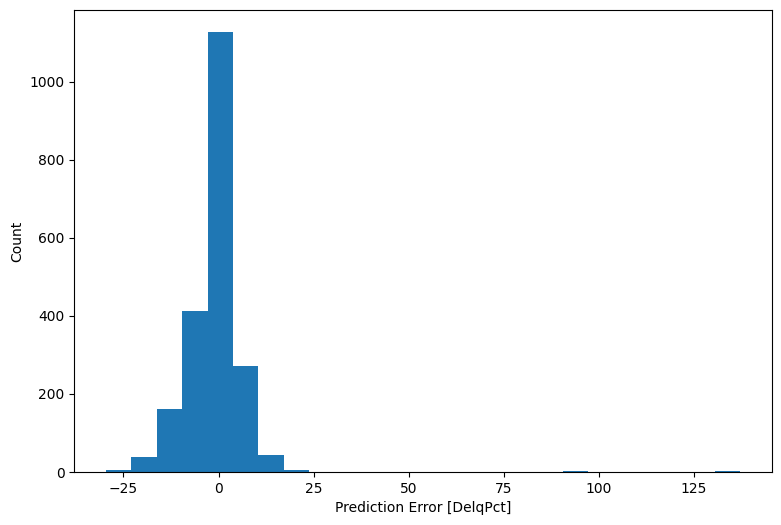

In [58]:
test_predictions = dnn_model.predict(test_features).flatten()

print(test_predictions[:5])
print(test_labels[:5])

error = test_predictions.reshape(test_predictions.shape[0],1) - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [DelqPct]')
_ = plt.ylabel('Count')

### XGBoost

In [59]:
xgdata = df.copy(deep=True)
for x in tqdm(range(100)):
    x_train, x_test, y_train, y_test = train_test_split(xgdata.iloc[:,:-1], xgdata.iloc[:,-1:], test_size=0.2)

    train = xgb.DMatrix(x_train, label=y_train)
    test = xgb.DMatrix(x_test, label=y_test)

    param = {
        'eta': 0.01,
        'objective': 'reg:squarederror',
    }
    epochs = 500

    model = xgb.train(param, train, epochs)

    predictions = model.predict(test)

    y = []

    for z in predictions:
        y.append(np.argmax(z))

    acc = round(metrics.mean_squared_error(y_test, y, squared=False), 3)
    model.save_model('Models/Delq/XGBoost_{}%_Scorelate.json'.format(acc))

100%|█████████████████████████████████████████| 100/100 [09:44<00:00,  5.84s/it]


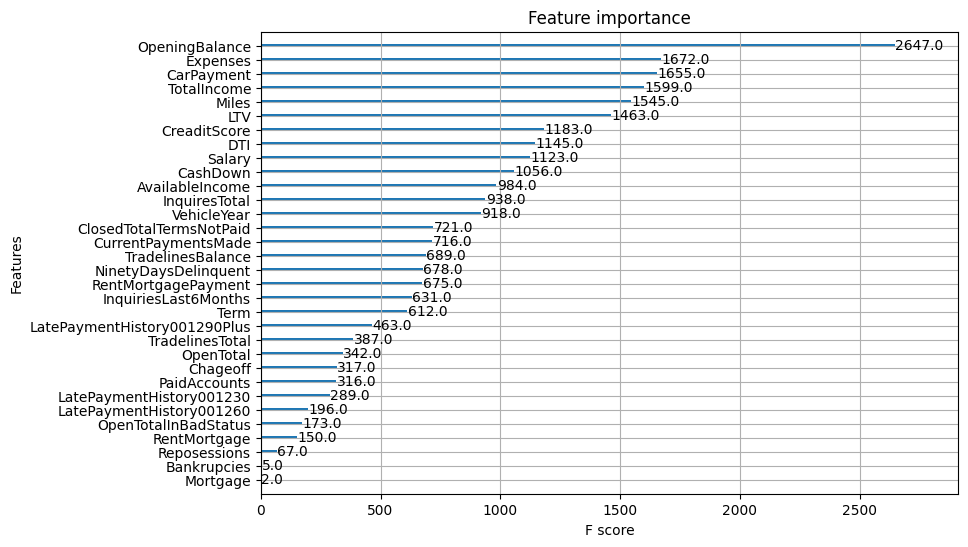

In [60]:
xgb_ml = xgb.Booster()
xgb_ml.load_model('Models/Delq/XGBoost_6.582%_Scorelate.json')


# plot feature importance
plot_importance(xgb_ml)
plt.show()

In [67]:
#XGBoost but with outliers removed
xgdata = nooutliers.copy(deep=True)
for x in tqdm(range(10)):
    x_train, x_test, y_train, y_test = train_test_split(xgdata.iloc[:,:-1], xgdata.iloc[:,-1:], test_size=0.2)

    train = xgb.DMatrix(x_train, label=y_train)
    test = xgb.DMatrix(x_test, label=y_test)

    param = {
        'eta': 0.01,
        'objective': 'reg:squarederror',
    }
    epochs = 500

    model = xgb.train(param, train, epochs)

    predictions = model.predict(test)

    y = []

    for z in predictions:
        y.append(np.argmax(z))

    acc = round(metrics.mean_squared_error(y_test, y, squared=False), 3)
    model.save_model('Models/Delq/XGBoost_{}%_Scorelate.json'.format(acc))

100%|███████████████████████████████████████████| 10/10 [00:48<00:00,  4.89s/it]


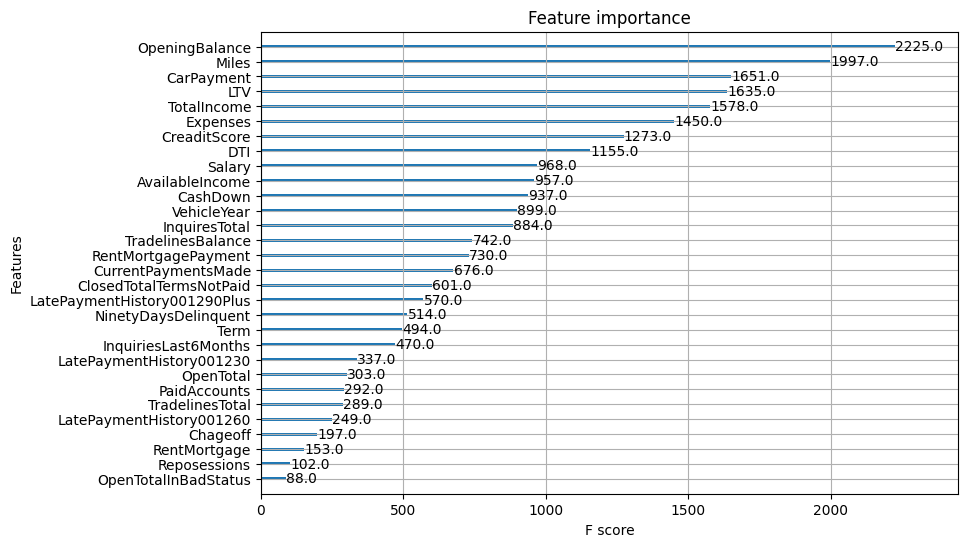

In [68]:
xgb_ml = xgb.Booster()
xgb_ml.load_model('Models/Delq/XGBoost_6.204%_Scorelate.json')


# plot feature importance
plot_importance(xgb_ml)
plt.show()

In [72]:
#xgboost but minmax normalized
xgdata = normalized_df.copy(deep=True)
for x in tqdm(range(10)):
    x_train, x_test, y_train, y_test = train_test_split(xgdata.iloc[:,:-1], xgdata.iloc[:,-1:], test_size=0.2)

    train = xgb.DMatrix(x_train, label=y_train)
    test = xgb.DMatrix(x_test, label=y_test)

    param = {
        'eta': 0.01,
        'objective': 'reg:squarederror',
    }
    epochs = 500

    model = xgb.train(param, train, epochs)

    predictions = model.predict(test)

    y = []

    for z in predictions:
        y.append(np.argmax(z))
        
    acc = round(metrics.mean_squared_error(y_test, y, squared=False), 3)
    model.save_model('Models/Delq/XGBoost_{}%_Scorelate.json'.format(acc))
    
print(predictions[:5])
print(y_test[:5])

100%|███████████████████████████████████████████| 10/10 [01:26<00:00,  8.61s/it]

[0.194122   0.08406827 0.07448531 0.10954425 0.10671004]
        DelqPct
7344   0.000000
5880   0.075046
2219   0.000000
7247   0.000000
12543  0.000000


In [79]:
print(df['DelqPct'][7344])
print(df['DelqPct'][5880])
print(df['DelqPct'][2219])
print(df['DelqPct'][7247])
print(df['DelqPct'][12543])

0.0
2.3837405330152595
0.0
0.0
0.0


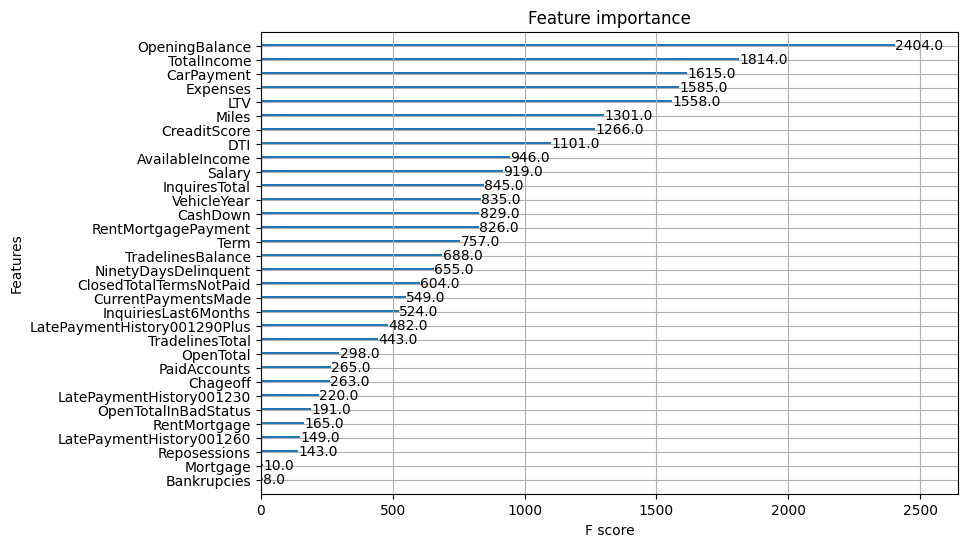

In [80]:
xgb_ml = xgb.Booster()
xgb_ml.load_model('Models/Delq/XGBoost_0.206%_Scorelate.json')

# plot feature importance
plot_importance(xgb_ml)
plt.show()